# Playground 
**Tuesday, Nov 13, 2018**

- Documentation site of WFDB: http://wfdb.readthedocs.io/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

## Reading records and annotations

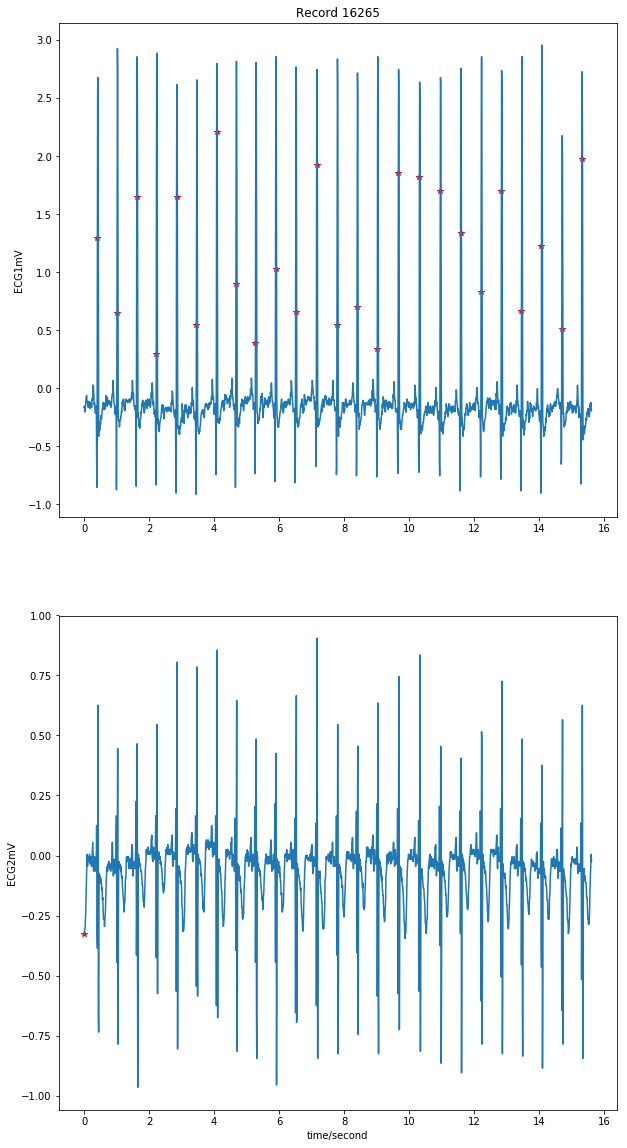

{'record_name': '16265', 'n_sig': 2, 'fs': 128, 'counter_freq': None, 'base_counter': None, 'sig_len': 2000, 'base_time': datetime.time(8, 4), 'base_date': None, 'comments': ['32 M'], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[-0.165, -0.325],
       [-0.155, -0.325],
       [-0.195, -0.305],
       ...,
       [-0.125, -0.005],
       [-0.175,  0.005],
       [-0.195, -0.025]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['16265.dat', '16265.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-33, -65], 'checksum': [42310, 36976], 'block_size': [0, 0]}


In [2]:
# Demo 1 - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord('../nsrDb/16265', sampto=2000) 
annotation = wfdb.rdann('../nsrDb/16265', 'atr', sampto = 2000)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 16265',
               time_units='seconds', figsize=(10,20))

print(record.__dict__)

In [4]:
record = wfdb.rdrecord('../nsrDb/16265')
print(record.__dict__['sig_len'])
print(record.__dict__['sig_name'])

11730944
['ECG1', 'ECG2']


In [5]:
raw = record.__dict__['p_signal']
fs = record.fs
print(fs)
print(raw.shape)
print(raw)

128
(11730944, 2)
[[-0.165 -0.325]
 [-0.155 -0.325]
 [-0.195 -0.305]
 ...
 [-0.05  -0.095]
 [-0.05  -0.085]
 [-0.05  -0.085]]


## Use the gqrs detection algorithm

In [10]:
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

In [8]:
# Use the gqrs algorithm to detect qrs locations in the first channel
qrs_inds = processing.gqrs_detect(sig=raw[:2001,1], fs=record.fs)
qrs_inds

array([  50,  130,  207,  285,  361,  440,  519,  599,  676,  754,  831,
        913,  997, 1076, 1156, 1235, 1318, 1404, 1483, 1565, 1642, 1724,
       1802, 1883, 1966])

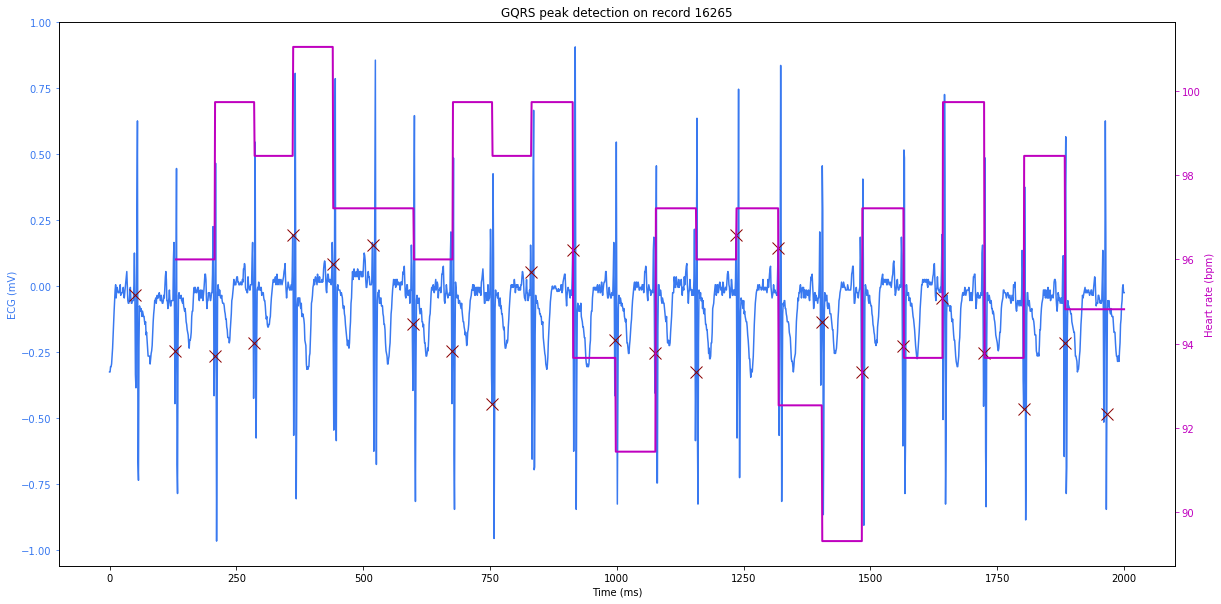

In [11]:
# Plot results
peaks_hr(sig=raw[:2001,1], peak_inds=qrs_inds, fs=record.fs,
        title="GQRS peak detection on record 16265")
    

## Use the xqrs detection algorithm and compare results to reference annotations

/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inst

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
483 reference annotations, 482 test annotations

True Positives (matched samples): 482
False Positives (unmatched test samples: 0
False Negatives (unmatched reference samples): 1

Specificity: 0.9979 (482/483)
Positive Predictivity: 1.0000 (482/482)
False Positive Rate: 0.0000 (0/482)


/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


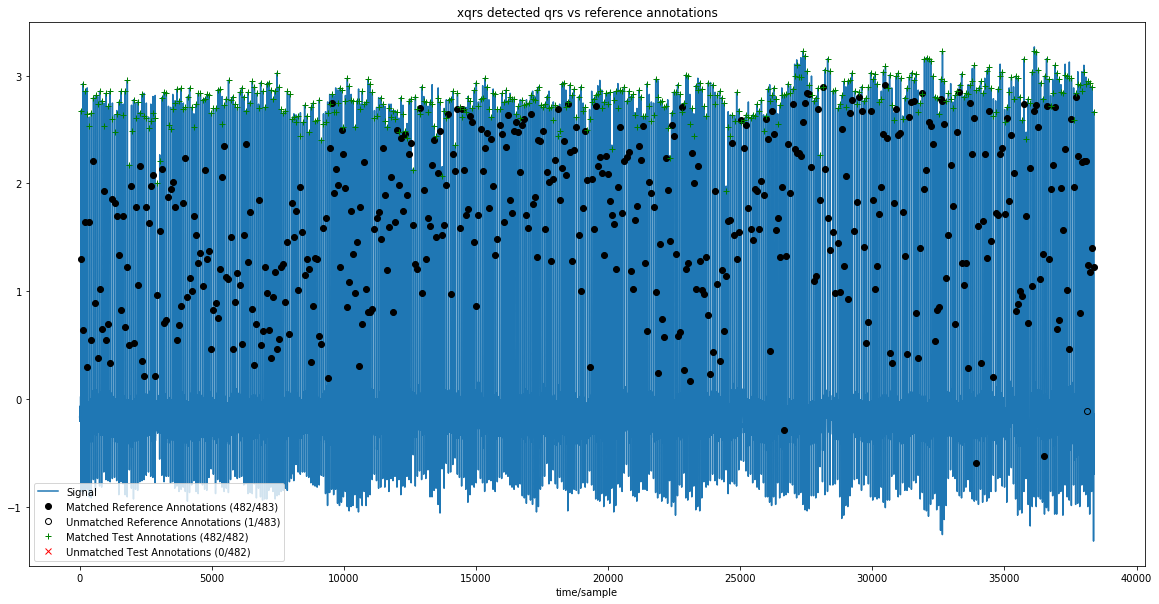

In [12]:
sig, fields = wfdb.rdsamp('../nsrDb/16265', channels=[0], sampto=38400)
ann_ref = wfdb.rdann('../nsrDb/16265','atr', sampto=38400)

# Run qrs detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the qrs indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected qrs complexes to reference annotation.
# Note, first sample in 100.atr is not a qrs.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected qrs vs reference annotations', figsize=(20,10))